In [ ]:
%pip install -q tensorflow-probability

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf


class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta  #should be within 0.25 to 2
        # Code book initialization
        codebook_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=codebook_init(shape=(self.embedding_dim, self.num_embeddings), dtype="float32"),
            trainable=True,
            name="codebook_embedding",
        )

    def call(self, x):
        shape = tf.shape(x)
        # reshape it to the shape (embedding_num, embedding_dim)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        '''Calculation to get quantization.'''
        # Get the index of the vectors in the embedding codebook.
        codebook_indices = self.get_codebook_indices(flattened)
        # One hot encoding to encode indices
        encodings = tf.one_hot(codebook_indices, self.num_embeddings)
        # Get the quantized vector
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        # Reshape back
        quantized = tf.reshape(quantized, shape)


        # The loss is norm2(stop_gradient(encoder_vector) - decoder_vector) + beta * norm2(encoder_vector - stop_gradient(decoder_vector))
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Estimator.
        quantized = x + tf.stop_gradient(quantized - x)

        return quantized

    def get_codebook_indices(self, input):
        # Calculate norm2 between the input vectors and the codebook vectors.
        similarity = tf.matmul(input, self.embeddings)
        distances = (
            tf.reduce_sum(input ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0) - 2 * similarity
        )

        # Get the closest indices
        closest_indices = tf.argmin(distances, axis=1)
        return closest_indices

class Encoder():
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.model = self.gen_encoder()

    def gen_encoder(self):
        input = keras.Input(shape=(256, 256, 1))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(input)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
        encoder_outputs = layers.Conv2D(self.latent_dim, 1, padding="same")(x)
        return keras.Model(input, encoder_outputs, name="encoder")

    def get_model(self):
        return self.model

class Decoder():
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.model = self.gen_decoder()

    def gen_decoder(self):
        input = keras.Input(shape=(32, 32, 30))
        x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(input)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        # x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
        return keras.Model(input, decoder_outputs, name="decoder")

    def get_model(self):
        return self.model


class VQ_VAE():
    def __init__(self, input_shape, latent_dim, embedding_num):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.embedding_num = embedding_num
        self.encoder = Encoder(latent_dim=latent_dim).get_model()
        self.decoder = Decoder(latent_dim=latent_dim).get_model()
        self.model = self.gen_vq_vae()
        print(self.encoder.summary())
        print(self.decoder.summary())

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def get_model(self):
        return self.model
        
    def gen_vq_vae(self):
        input = keras.Input(shape=self.input_shape)
        encoder_output = self.encoder(input)
        latent_vector = VectorQuantizer(self.embedding_num, self.latent_dim, 0.5)(encoder_output)
        decoder_output = self.decoder(latent_vector)
        return keras.Model(input, decoder_output, name='vq_vae')

# def get_vqvae(latent_dim=16, num_embeddings=64):
#     vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
#     encoder = get_encoder(latent_dim)
#     print(encoder.summary())
#     decoder = get_decoder(latent_dim)
#     print(decoder.summary())
#     inputs = keras.Input(shape=(256, 256, 1))
#     encoder_outputs = encoder(inputs)
#     quantized_latents = vq_layer(encoder_outputs)
#     reconstructions = decoder(quantized_latents)
#     return keras.Model(inputs, reconstructions, name="vq_vae")


class Trainer(keras.models.Model):
    def __init__(self, img_shape, latent_dim, num_embeddings, variance, **kwargs):
        super(Trainer, self).__init__(**kwargs)     
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.variance = variance
        self.vq_vae = VQ_VAE(self.img_shape, self.latent_dim, self.num_embeddings).get_model()
        self.total_loss = keras.metrics.Mean(name="loss")
        self.reconstruction_loss = keras.metrics.Mean(name="reconstruction_loss")
        self.vq_loss = keras.metrics.Mean(name="vq_loss")  

    @property
    def metrics(self):
        return [
            self.total_loss,
            self.reconstruction_loss,
            self.vq_loss,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vq_vae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.variance
            )
            total_loss = reconstruction_loss + sum(self.vq_vae.losses)

        print('gradient calculated')
        # Backpropagation.
        grads = tape.gradient(total_loss, self.vq_vae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vq_vae.trainable_variables))

        # Update losses.
        self.total_loss.update_state(total_loss)
        self.reconstruction_loss.update_state(reconstruction_loss)
        self.vq_loss.update_state(sum(self.vq_vae.losses))
        print('updated')

        # Log results.
        return {
            "loss": self.total_loss.result(),
            "reconstruction_loss": self.reconstruction_loss.result(),
            "vqvae_loss": self.vq_loss.result(),
        }


class VQVAETrainer(keras.models.Model):
    def __init__(self, img_shape, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.vqvae = VQ_VAE(img_shape, self.latent_dim, self.num_embeddings).get_model()

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


# def get_encoder(latent_dim=16):
#     encoder_inputs = keras.Input(shape=(256, 256, 1))
#     # x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
#     x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
#     x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
#     x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
#     encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
#     return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


# def get_decoder(latent_dim=16):
#     latent_inputs = keras.Input(shape=(get_encoder(latent_dim).output.shape[1:]))
#     x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(
#         latent_inputs
#     )
#     x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
#     x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
#     # x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
#     decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
#     return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
print(tf.__version__)
import matplotlib, PIL

print(matplotlib.__version__)
print(np.__version__)
print(PIL.__version__)
print(tfp.__version__)

2.9.2
3.2.2
1.21.6
7.1.2
0.16.0


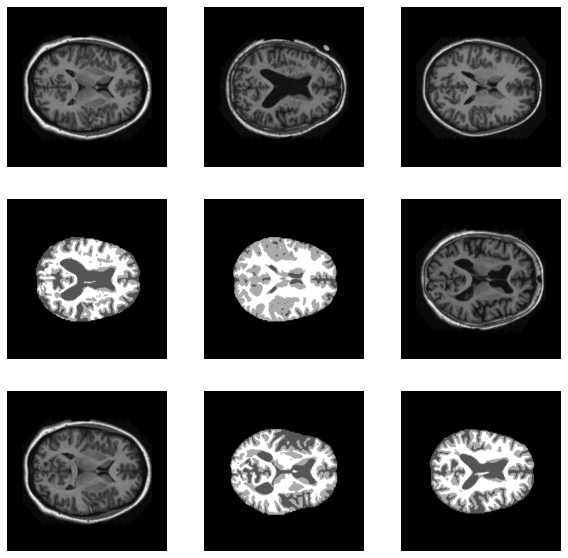

In [ ]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().squeeze().astype("float32"), cmap='gray', vmin=0, vmax=255)
    #plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# import tensorflow_datasets as tfds
# example = tfds.as_numpy(train_ds.take(3))
# print(np.array(example))
# data_variance = tfp.stats.variance(tf.convert_to_tensor(example))
# vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
# vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
# vqvae_trainer.fit(train_ds_scaled, epochs=30, batch_size=128)

import os
from google.colab import drive
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import glob
import numpy as np
from time import time
from time import sleep

drive.mount('/content/drive/')
path = "/content/drive/My Drive/comp3710/project/keras_png_slices_data/keras_png_slices_data"
train_path = ["/content/drive/My Drive/comp3710/project/keras_png_slices_data/keras_png_slices_data/keras_png_slices_train", "/content/drive/My Drive/comp3710/project/keras_png_slices_data/keras_png_slices_data/keras_png_slices_seg_train"]
test_path = ["/content/drive/My Drive/comp3710/project/keras_png_slices_data/keras_png_slices_data/keras_png_slices_test", "/content/drive/My Drive/comp3710/project/keras_png_slices_data/keras_png_slices_data/keras_png_slices_test"]

train_ds = []
for p in train_path:
    for f in glob.iglob(p+'/*'):
        train_ds.append(np.asarray(Image.open(f)))
    #onlyfiles.extend([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])

train_ds = np.array(train_ds)[:15000]
print(train_ds.shape)


Mounted at /content/drive/
(15000, 256, 256)


In [ ]:
test_ds = []
for p in test_path:
    for f in glob.iglob(p+'/*'):
        test_ds.append(np.asarray(Image.open(f)))

test_ds = np.array(test_ds)

In [ ]:
train_ds = np.expand_dims(train_ds, -1)
test_ds = np.expand_dims(test_ds, -1)
data_variance = np.var(train_ds / 255.0)
train_ds = (train_ds / 255.0) - 0.5
x_test_scaled = (test_ds / 255.0) - 0.5



In [ ]:
# vqvae_trainer = VQVAETrainer(img_shape=(256, 256, 1), train_variance=data_variance, latent_dim=30, num_embeddings=128)
checkpoint_path = '/content/drive/My Drive/comp3710/project/saved_model/my_model'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
vqvae_trainer = Trainer(img_shape=(256, 256, 1), latent_dim=30, num_embeddings=128, variance=data_variance)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(train_ds, epochs=50, batch_size=128, callbacks=[cp_callback])

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 30)        3870      
                                                                 
Total params: 96,542
Trainable params: 96,542
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________

dict_keys(['loss', 'reconstruction_loss', 'vqvae_loss'])


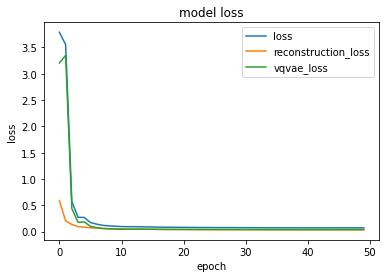

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['vqvae_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'reconstruction_loss', 'vqvae_loss'], loc='upper right')
plt.show()

In [ ]:
new_model = Trainer(img_shape=(256, 256, 1), latent_dim=30, num_embeddings=128, variance=data_variance)
checkpoint_path = '/content/drive/My Drive/comp3710/project/saved_model/my_model'
new_model.load_weights(checkpoint_path)
predicted = new_model.vq_vae.predict(x_test_scaled)
print(predicted.shape)
ssim2_total = tf.zeros([1, 1], dtype=tf.float32)

for test_image, reconstructed_image in zip(x_test_scaled, predicted):
    test_image = tf.convert_to_tensor(test_image)
    pre_image = tf.convert_to_tensor(reconstructed_image)
    test_image = tf.expand_dims(test_image, axis=0)
    pre_image = tf.expand_dims(pre_image, axis=0)
    test_image = tf.image.convert_image_dtype(test_image, tf.float32)
    pre_image = tf.image.convert_image_dtype(pre_image, tf.float32)
    ssim2 = tf.image.ssim(test_image, pre_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
    ssim2_total = ssim2 + ssim2_total

print(ssim2_total/predicted.shape[0])
print(predicted.shape[0])

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 30)        3870      
                                                                 
Total params: 96,542
Trainable params: 96,542
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________

In [ ]:
predicted = vqvae_trainer.vq_vae.predict(x_test_scaled)
print(predicted.shape)

34/34 [==============================] - 3s 52ms/step
(1088, 256, 256, 1)


In [ ]:
ssim2_total = tf.zeros([1, 1], dtype=tf.float32)

for test_image, reconstructed_image in zip(x_test_scaled, predicted):
    test_image = tf.convert_to_tensor(test_image)
    pre_image = tf.convert_to_tensor(reconstructed_image)
    test_image = tf.expand_dims(test_image, axis=0)
    pre_image = tf.expand_dims(pre_image, axis=0)
    test_image = tf.image.convert_image_dtype(test_image, tf.float32)
    pre_image = tf.image.convert_image_dtype(pre_image, tf.float32)
    ssim2 = tf.image.ssim(test_image, pre_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
    ssim2_total = ssim2 + ssim2_total

print(ssim2_total/predicted.shape[0])
print(predicted.shape[0])
# for i in range(predicted.shape[0]):
#     print(x_test_scaled.shape)
#     ssim2 = tf.image.ssim(x_test_scaled[i], predicted[i], max_val=1.0, 
#                           filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
#     ssim2_total = ssim2 + ssim2_total
    

tf.Tensor([[0.8575265]], shape=(1, 1), dtype=float32)
1088


1/1 [==============================] - 0s 17ms/step


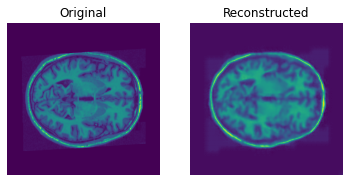

tf.Tensor([0.8447678], shape=(1,), dtype=float32)


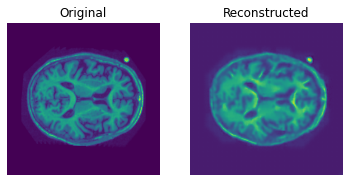

tf.Tensor([0.8190848], shape=(1,), dtype=float32)


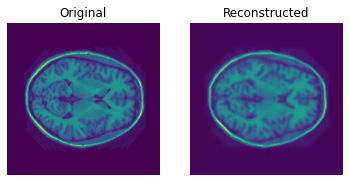

tf.Tensor([0.8491614], shape=(1,), dtype=float32)


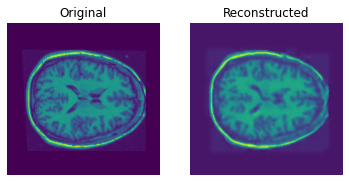

tf.Tensor([0.81469417], shape=(1,), dtype=float32)


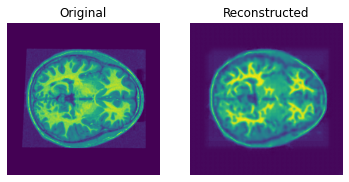

tf.Tensor([0.7514375], shape=(1,), dtype=float32)


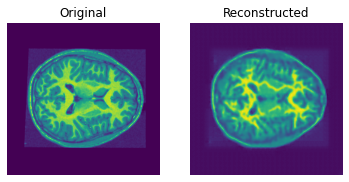

tf.Tensor([0.7491321], shape=(1,), dtype=float32)


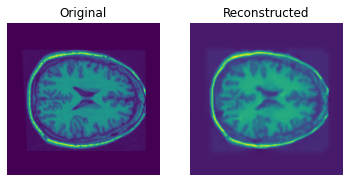

tf.Tensor([0.82928777], shape=(1,), dtype=float32)


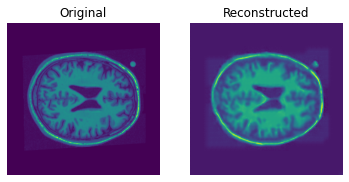

tf.Tensor([0.8698008], shape=(1,), dtype=float32)


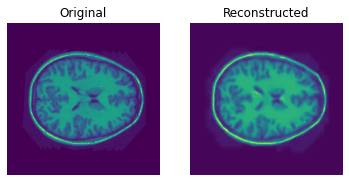

tf.Tensor([0.8330322], shape=(1,), dtype=float32)


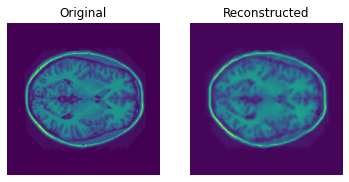

tf.Tensor([0.85521215], shape=(1,), dtype=float32)


In [ ]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vq_vae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for i in range(10):
    tf.keras.preprocessing.image.save_img('/content/drive/My Drive/comp3710/project/save_image/' + str(i) + '.jpg', reconstructions_test[i])
    #tf.keras.utils.save_img('/content/drive/My Drive/comp3710/project/save_image/' + str(i) + '/jpg', reconstructions_test[i])

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)
    test_image = tf.convert_to_tensor(test_image)
    pre_image = tf.convert_to_tensor(reconstructed_image)
    test_image = tf.expand_dims(test_image, axis=0)
    pre_image = tf.expand_dims(pre_image, axis=0)
    test_image = tf.image.convert_image_dtype(test_image, tf.float32)
    pre_image = tf.image.convert_image_dtype(pre_image, tf.float32)
    ssim2 = tf.image.ssim(test_image, pre_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
    print(ssim2)